**Урок 8. Python применение статистических критериев на практике - пайплайн оценки A/B**

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [27]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IGMgJP_XqQwA6h_w1KYG7TQJhS15h4c4',
                                    dest_path='./AB_Test_Results (2)');

In [31]:
df = pd.read_excel('AB_Test_Results (2)')

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [4]:
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


Количество пользователей по группам

In [7]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

In [11]:
#Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

v = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [12]:
v.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [14]:
more_than_one_types = v.query('VARIANT_NAME > 1')

In [15]:
df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [16]:
df_new.shape

(6070, 3)

In [17]:
df.shape

(10000, 3)

In [19]:
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [20]:
len(control)

3026

In [21]:
len(test)

3044

Проверка данных на нормальность.
Наблюдений меньше 5000  - применяем критерий Шапиро-Уилка

In [25]:
alpha = 0.05

st = shapiro(df.REVENUE)
print('Распределение  {}нормальное\n'.format( {True:'не ',
False:''}[st[1] < alpha]));

Распределение  не нормальное



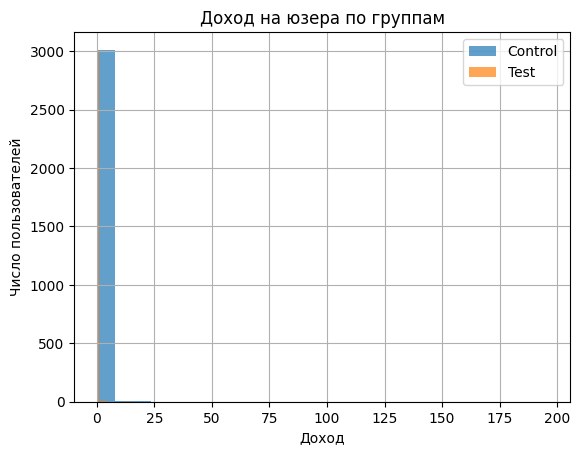

In [26]:
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

Распределение не нормальное. Применяем критерий Манна — Уитни.

In [28]:
statistic, p_value = mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)

In [29]:
print("Статистика теста:", statistic)
print("p-value:", p_value)

Статистика теста: 4622832.0
p-value: 0.2444173738649208


In [30]:
alpha = 0.05
if p_value < alpha:
    print("Существуют статистически значимые различия между группами control и test.")
else:
    print("Нет статистически значимых различий между группами control и test.")

Нет статистически значимых различий между группами control и test.


**Рекомендации: различия не статистически значимы, рекомендуется продолжать мониторить результаты теста или увеличить объем выборки для более точного анализа.**